In [1]:
import requests
import pandas as pd
from time import sleep
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from prophet import Prophet


# Specify the file path to save the compressed CSV
csv_file_path = 'historical_crime.csv.gz'



In [2]:
# Define the base URL for the API
base_url = "https://data.cityofnewyork.us/resource/8h9b-rp9u.json"

# Define headers including the app token
headers = {
    'X-App-Token': 'gcDEQgxy8Z5tdm905ovo9OhrQ'
}

# Function to handle pagination, fetch all data, and implement a delay between requests
def fetch_all_data(base_url, headers):
    limit = 50000  # Adjust the limit as needed, depending on what the API allows
    offset = 0
    full_data = []

    while True:
        # Construct the query with pagination and date filtering
        query_url = f"{base_url}?$limit={limit}&$offset={offset}" \
                    f"&$where=ARREST_DATE between '2014-01-01T00:00:00.000' and '2023-12-31T23:59:59.999'"
        
        response = requests.get(query_url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch data: HTTP Status Code {response.status_code}")
            break
        
        data = response.json()
        if not data:
            break  # Break the loop if no more data is returned
        
        full_data.extend(data)
        offset += limit
        
        # Sleep for 5 seconds before making the next request
        sleep(5)
    
    return full_data

# Fetch all data using the defined function
all_data = fetch_all_data(base_url, headers)

# Create a DataFrame from the fetched data
historical_df = pd.DataFrame(all_data)

# Display the first few rows of the DataFrame to verify it
print(historical_df.head())
print(f"Total rows fetched: {len(historical_df)}")



  arrest_key              arrest_date pd_cd                          pd_desc  \
0   94273780  2014-01-01T00:00:00.000   397  ROBBERY,UNCLASSIFIED,OPEN AREAS   
1   94272165  2014-01-01T00:00:00.000   205             TRESPASS 2, CRIMINAL   
2   94273806  2014-01-01T00:00:00.000   750                 RESISTING ARREST   
3   94272052  2014-01-01T00:00:00.000   109         ASSAULT 2,1,UNCLASSIFIED   
4   94259980  2014-01-01T00:00:00.000   101                        ASSAULT 3   

  ky_cd                               ofns_desc    law_code law_cat_cd  \
0   105                                 ROBBERY  PL 1601001          F   
1   352                       CRIMINAL TRESPASS  PL 1401500          M   
2   359  OFFENSES AGAINST PUBLIC ADMINISTRATION  PL 2053000          M   
3   106                          FELONY ASSAULT  PL 1200501          F   
4   344            ASSAULT 3 & RELATED OFFENSES  PL 1200001          M   

  arrest_boro arrest_precinct jurisdiction_code age_group perp_sex  \
0   

In [15]:
# Write the DataFrame to a GZIP-compressed CSV file
historical_df.to_csv(csv_file_path, index=False, compression='gzip')
historical_df = historical_df.dropna()

print(historical_df.shape[0])

2483414


In [16]:
# Read a compressed CSV file (e.g., gzip-compressed)
historical_df = pd.read_csv(csv_file_path, compression='gzip')

In [35]:
historical_df.head()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,lon_lat
0,94273780,2014-01-01,397.0,"ROBBERY,UNCLASSIFIED,OPEN AREAS",105.0,ROBBERY,PL 1601001,F,B,44,0,<18,M,BLACK,1006032.0,243764.0,40.835733,-73.921285,"{'type': 'Point', 'coordinates': [-73.92128542..."
1,94272165,2014-01-01,205.0,"TRESPASS 2, CRIMINAL",352.0,CRIMINAL TRESPASS,PL 1401500,M,M,26,2,25-44,M,BLACK,996014.0,236126.0,40.814787,-73.957502,"{'type': 'Point', 'coordinates': [-73.95750196..."
2,94273806,2014-01-01,750.0,RESISTING ARREST,359.0,OFFENSES AGAINST PUBLIC ADMINISTRATION,PL 2053000,M,K,60,2,25-44,M,BLACK,986860.0,149123.0,40.575992,-73.990606,"{'type': 'Point', 'coordinates': [-73.99060607..."
3,94272052,2014-01-01,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200501,F,B,41,0,25-44,F,WHITE,1012777.0,237339.0,40.818079,-73.896938,"{'type': 'Point', 'coordinates': [-73.89693760..."
4,94259980,2014-01-01,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,B,42,2,25-44,M,WHITE HISPANIC,1010896.0,244231.0,40.837001,-73.903706,"{'type': 'Point', 'coordinates': [-73.90370600..."


In [ ]:
# Converting the list of data into a DataFrame
##historical_df = pd.DataFrame(all_data)
#historical_df

In [17]:
historical_df.dtypes

arrest_key             int64
arrest_date           object
pd_cd                float64
pd_desc               object
ky_cd                float64
ofns_desc             object
law_code              object
law_cat_cd            object
arrest_boro           object
arrest_precinct        int64
jurisdiction_code      int64
age_group             object
perp_sex              object
perp_race             object
x_coord_cd           float64
y_coord_cd           float64
latitude             float64
longitude            float64
lon_lat               object
dtype: object

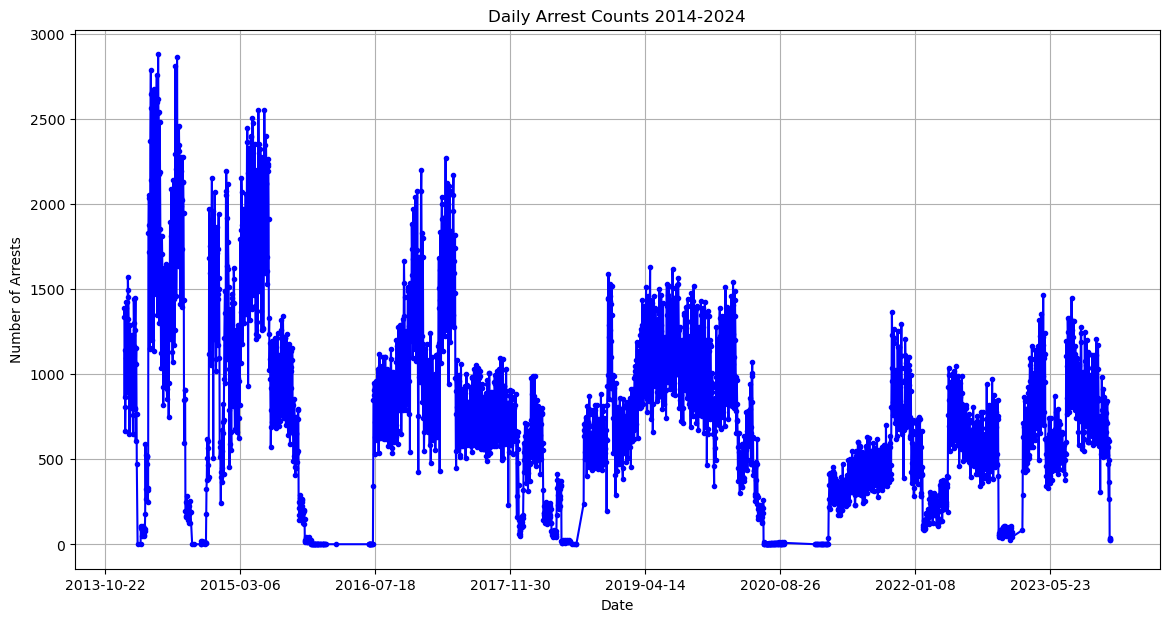

In [18]:
historical_df['arrest_date'] = pd.to_datetime(historical_df['arrest_date']).dt.date
arrest_counts = historical_df.groupby('arrest_date').size()

plt.figure(figsize=(14, 7))  
arrest_counts.plot(kind='line', color='blue', marker='.', linestyle='-')  

plt.title('Daily Arrest Counts 2014-2024')  # 
plt.xlabel('Date')  
plt.ylabel('Number of Arrests')  
plt.grid(True)  

# Improve the x-axis ticks to show fewer dates for clarity
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust the number as needed

plt.show()

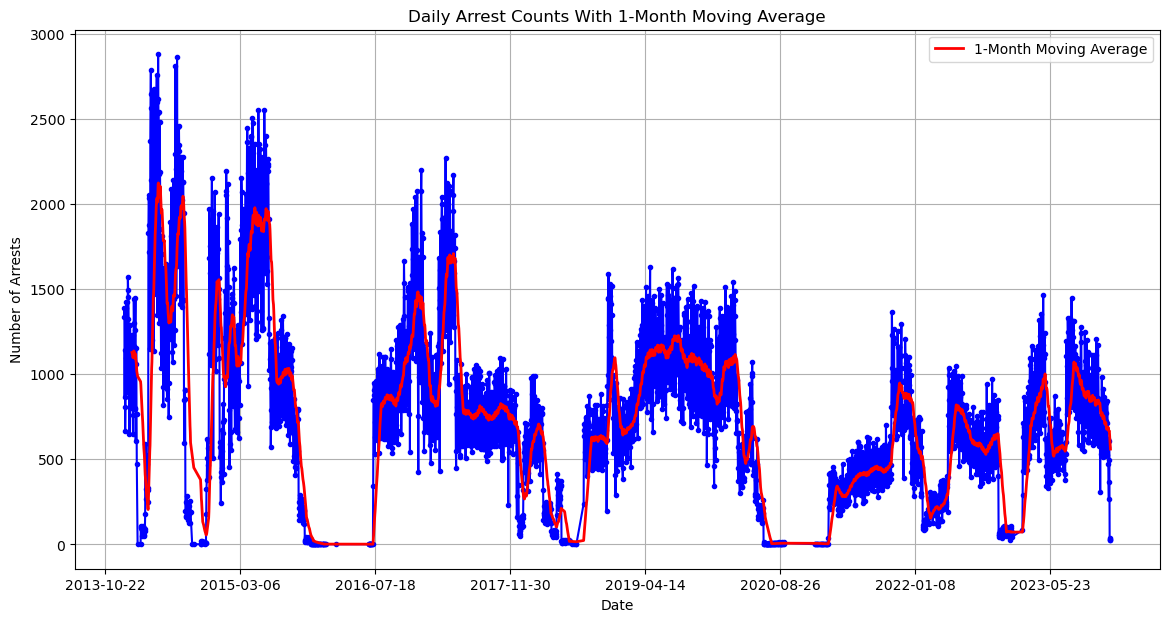

In [21]:
# Calculate the 30-day moving average of arrest counts
moving_average = arrest_counts.rolling(window=30).mean()

# Plot the moving average on top of the existing daily arrests plot
plt.figure(figsize=(14, 7))
arrest_counts.plot(kind='line', color='blue', marker='.', linestyle='-')  # Your existing daily plot
moving_average.plot(kind='line', color='red', linewidth=2, label='1-Month Moving Average')  # Moving average

plt.title('Daily Arrest Counts With 1-Month Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Arrests')
plt.legend()
plt.grid(True)

# Set major x-axis locator for clarity if there are many data points
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.show()

In [22]:
data = {
    "Year": ["2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"],
    "Bronx": [1430500, 1440000, 1443000, 1440000, 1432300, 1420000, 1461000, 1420100, 1380000, 1380000],
    "Manhattan": [1631700, 1637300, 1636700, 1632300, 1632400, 1632300, 1677300, 1578300, 1569300, 1569300],
    "Staten Island": [472000, 472300, 474200, 475800, 476500, 476100, 494600, 493500, 491100, 491100],
    "Queens": [2298234, 2305252, 2306249, 2295226, 2275286, 2253942, 2388586, 2328141, 2278029, 2278029],
    "Kings (Brooklyn)": [2601527, 2608797, 2608146, 2594357, 2580088, 2562329, 2719044, 2637486, 2590516, 2590516],
    "NYC Total": [8436961, 8450649, 8448295, 8424683, 8396874, 8343671, 8697530, 8486927, 8387845, 8387845]
}
# Convert the dictionary to a DataFrame
df_nyc_population = pd.DataFrame(data)

# Display the initial DataFrame
print(df_nyc_population)

   Year    Bronx  Manhattan  Staten Island   Queens  Kings (Brooklyn)  \
0  2014  1430500    1631700         472000  2298234           2601527   
1  2015  1440000    1637300         472300  2305252           2608797   
2  2016  1443000    1636700         474200  2306249           2608146   
3  2017  1440000    1632300         475800  2295226           2594357   
4  2018  1432300    1632400         476500  2275286           2580088   
5  2019  1420000    1632300         476100  2253942           2562329   
6  2020  1461000    1677300         494600  2388586           2719044   
7  2021  1420100    1578300         493500  2328141           2637486   
8  2022  1380000    1569300         491100  2278029           2590516   
9  2023  1380000    1569300         491100  2278029           2590516   

   NYC Total  
0    8436961  
1    8450649  
2    8448295  
3    8424683  
4    8396874  
5    8343671  
6    8697530  
7    8486927  
8    8387845  
9    8387845  


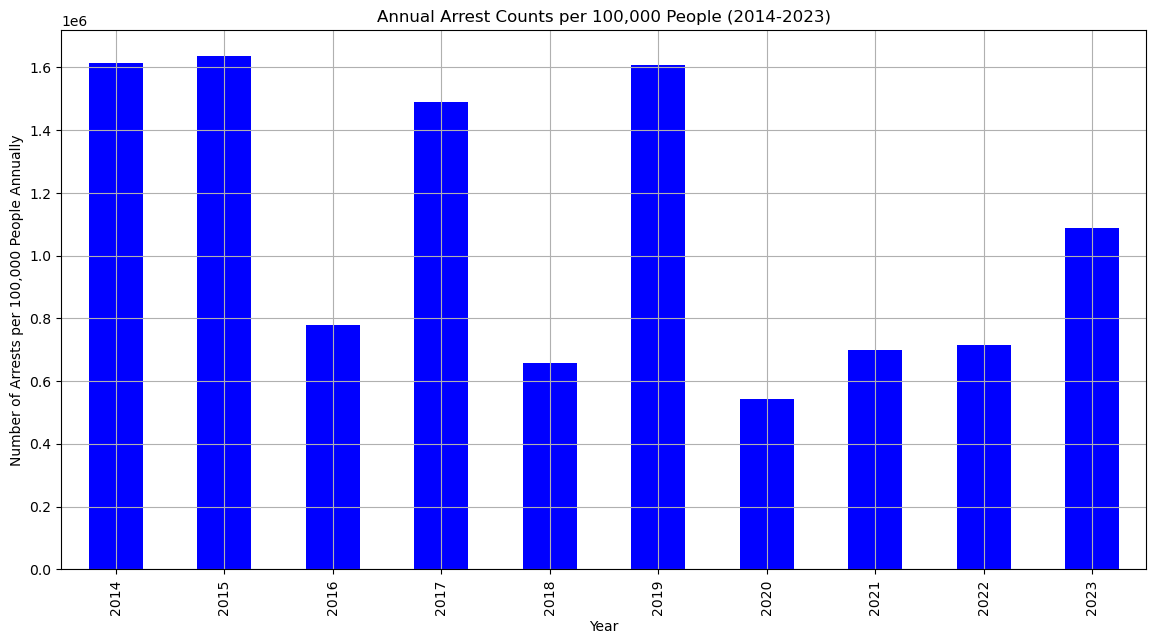

In [38]:
historical_df['arrest_date'] = pd.to_datetime(historical_df['arrest_date'])
historical_df['year'] = historical_df['arrest_date'].dt.year

# Aggregate arrests by year
annual_arrest_counts = historical_df.groupby('year').size()

# Load or ensure the population data is ready with 'Year' as an index
data = {
    "Year": [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    "NYC Total": [8436961, 8450649, 8448295, 8424683, 8396874, 8343671, 8697530, 8486927, 8387845, 8387845]
}
df_nyc_population = pd.DataFrame(data)
df_nyc_population.set_index('Year', inplace=True)  # Making sure 'Year' is the index

# Calculate arrests per 100,000 people for each year
# Multiply by 365 to normalize over the number of days in a year to get an annual rate
arrests_per_100k = (annual_arrest_counts / df_nyc_population['NYC Total']) * 100000 * 365

# Plotting the results
plt.figure(figsize=(14, 7))
arrests_per_100k.plot(kind='bar', color='blue')  # Using a bar plot for yearly data
plt.title('Annual Arrest Counts per 100,000 People (2014-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Arrests per 100,000 People Annually')
plt.grid(True)
plt.show()

20:56:14 - cmdstanpy - INFO - Chain [1] start processing
20:56:15 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


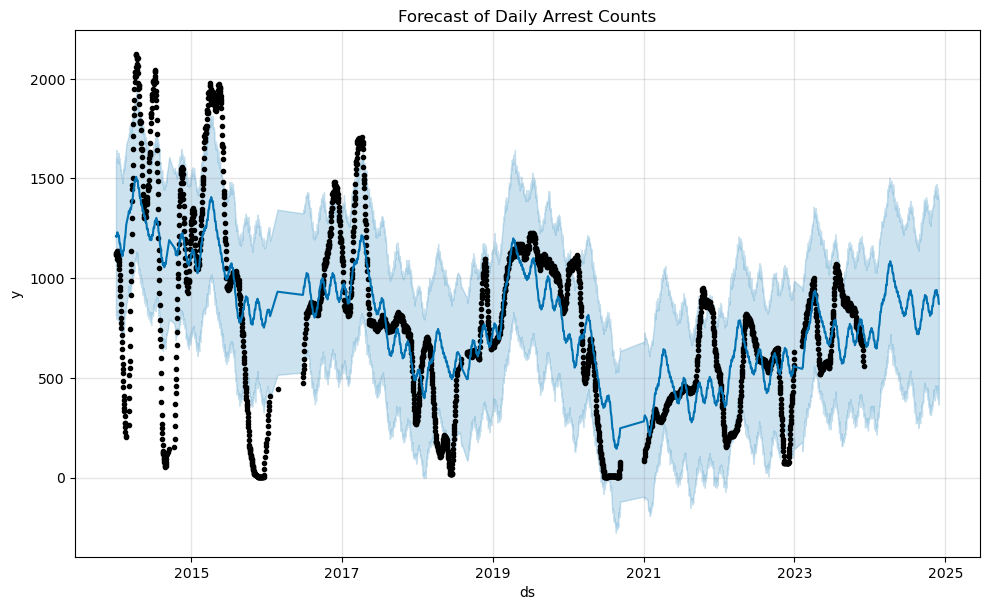

In [41]:
# Sample DataFrame creation, assuming 'historical_df' has been loaded correctly
# Check if the arrest counts are correctly summed daily, which seems likely okay from your previous description
historical_df['arrest_date'] = pd.to_datetime(historical_df['arrest_date'])
historical_df['year'] = historical_df['arrest_date'].dt.year

# Aggregating by arrest_date to ensure there are no errors
daily_arrest_counts = historical_df.groupby('arrest_date').size().reset_index(name='count')

# Calculate the 30-day moving average
daily_arrest_counts['Moving_Average'] = daily_arrest_counts['count'].rolling(window=30).mean().shift(-29)

# Drop NaNs which are generated by rolling mean at the start
daily_arrest_counts.dropna(inplace=True)

# Ensure there are enough data points
if daily_arrest_counts.shape[0] < 2:
    raise ValueError("Not enough data points to fit the model.")

# Preparing data for Prophet
df_prophet = daily_arrest_counts[['arrest_date', 'Moving_Average']]
df_prophet.columns = ['ds', 'y']  # Renaming for Prophet

# Fit the Prophet model
m = Prophet()
m.fit(df_prophet)

# Make a future dataframe for forecasting
future = m.make_future_dataframe(periods=365)

# Predict the future
forecast = m.predict(future)

# Plot the forecast
fig = m.plot(forecast)
plt.title('Forecast of Daily Arrest Counts')
plt.show()

In [43]:
historical_df['ofns_desc'].value_counts()

ofns_desc
ASSAULT 3 & RELATED OFFENSES              328245
DANGEROUS DRUGS                           319488
PETIT LARCENY                             219424
FELONY ASSAULT                            161372
VEHICLE AND TRAFFIC LAWS                  147672
                                           ...  
UNLAWFUL POSS. WEAP. ON SCHOOL GROUNDS         3
FELONY SEX CRIMES                              3
UNDER THE INFLUENCE, DRUGS                     2
KIDNAPPING AND RELATED OFFENSES                1
UNLAWFUL POSS. WEAP. ON SCHOOL                 1
Name: count, Length: 87, dtype: int64

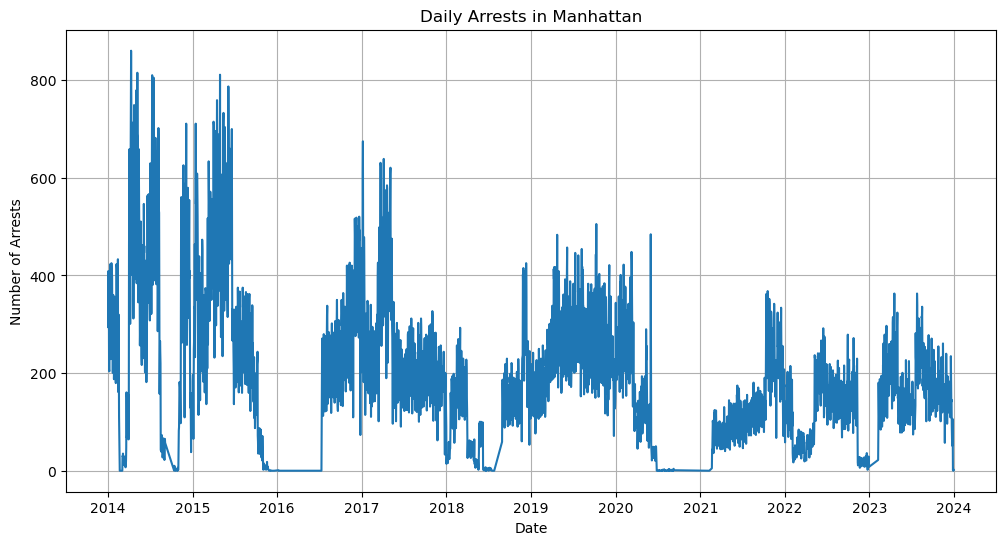

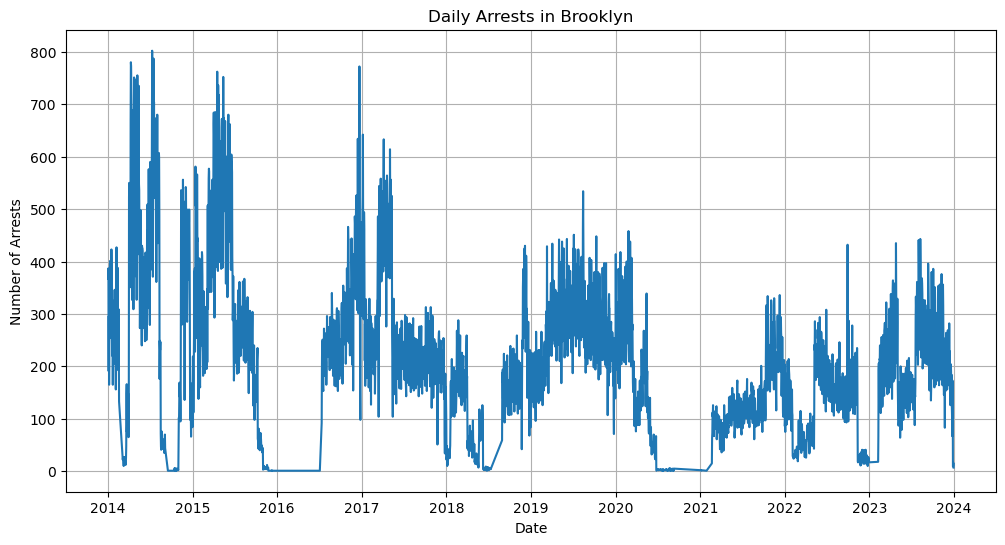

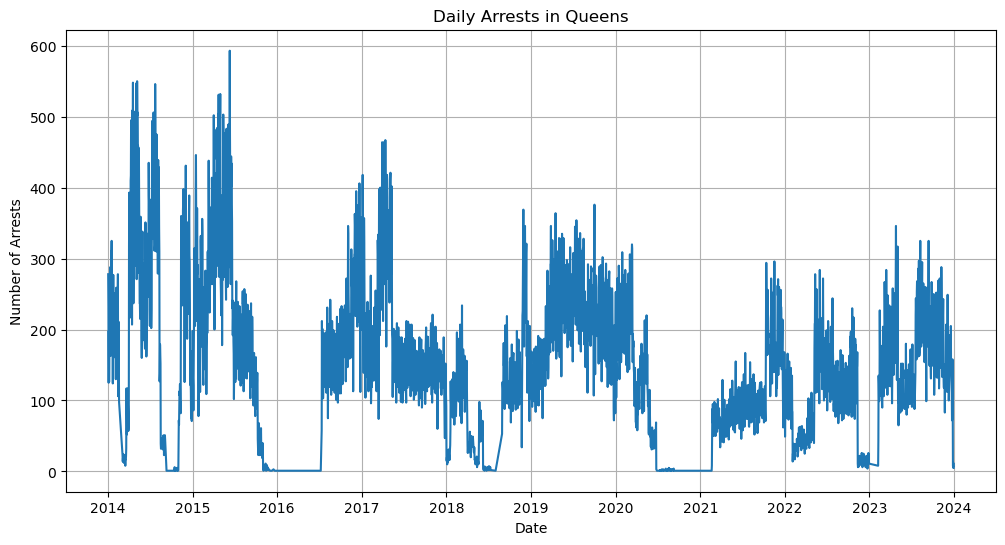

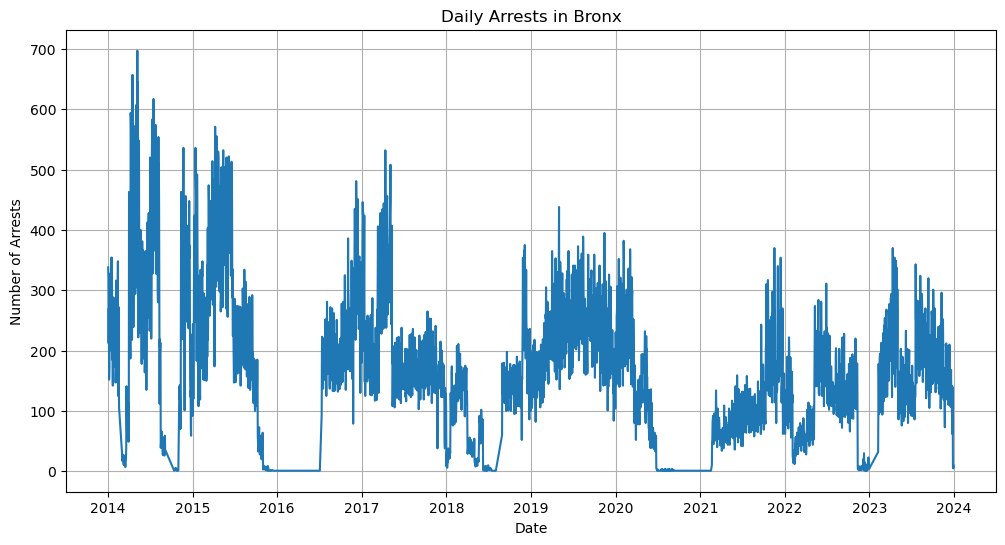

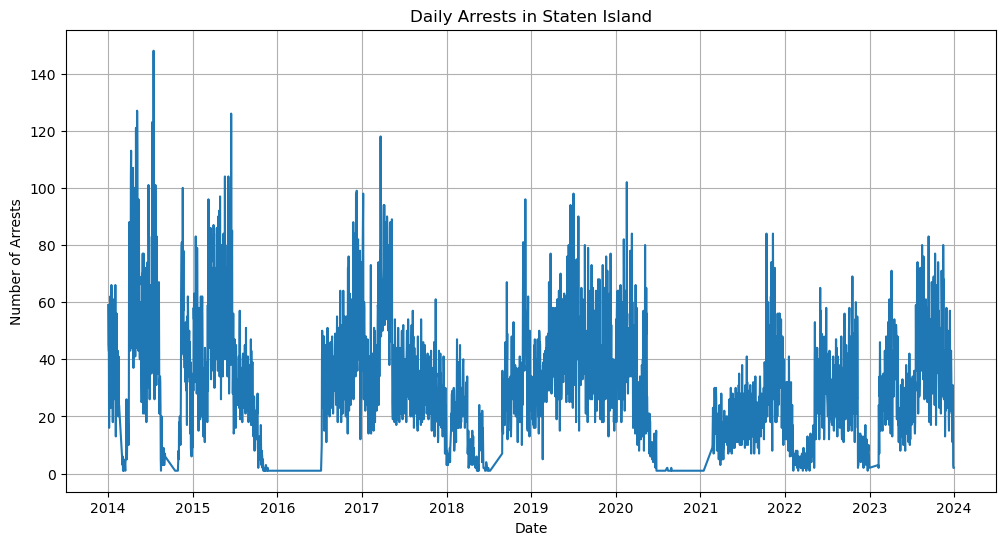

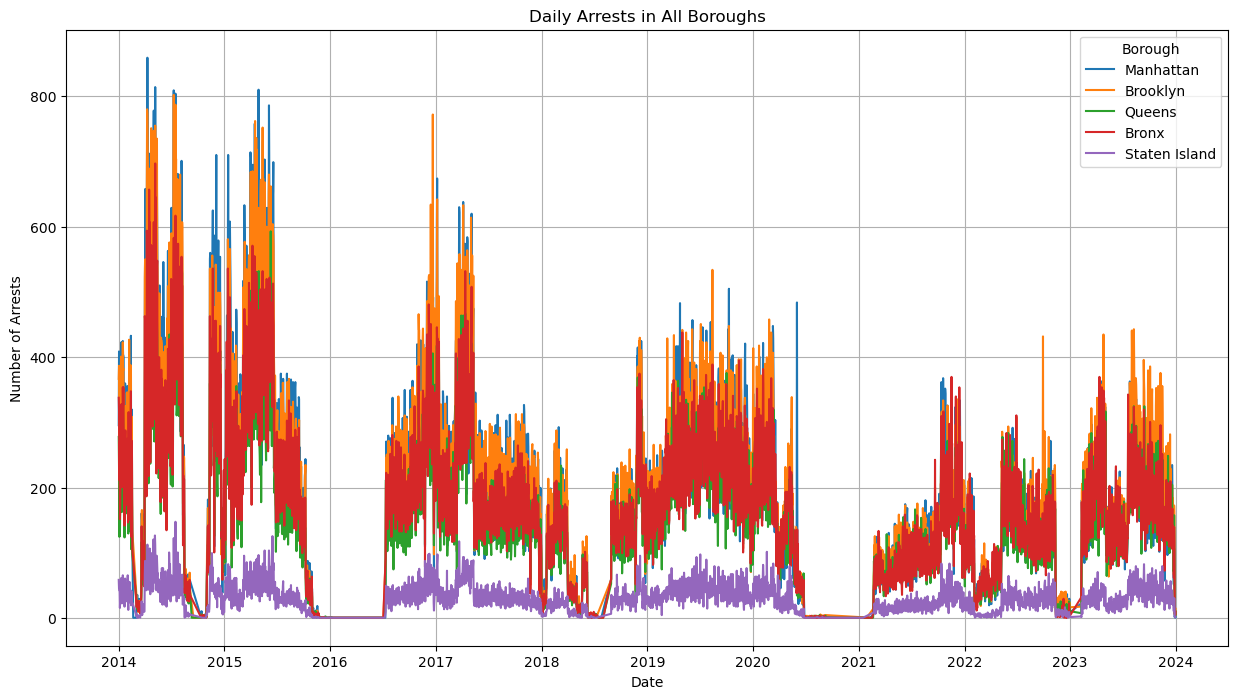

In [8]:
import matplotlib.pyplot as plt

# Define borough keys and labels for reference
borough_labels = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
borough_keys = ['M', 'K', 'Q', 'B', 'S']

# Plotting the data for each borough separately
for boro_key, boro_label in zip(borough_keys, borough_labels):
    # Filter data for the current borough
    borough_data = historical_df[historical_df['arrest_boro'] == boro_key]
    
    # Group by arrest_date and count the occurrences
    daily_counts = borough_data.groupby('arrest_date').size()
    
    # Plotting
    plt.figure(figsize=(12, 6))
    daily_counts.plot(title=f'Daily Arrests in {boro_label}')
    plt.xlabel('Date')
    plt.ylabel('Number of Arrests')
    plt.grid(True)
    plt.show()

# Combined plot for all boroughs
plt.figure(figsize=(15, 8))
for boro_key, boro_label in zip(borough_keys, borough_labels):
    # Filter data for the current borough
    borough_data = historical_df[historical_df['arrest_boro'] == boro_key]
    
    # Group by arrest_date and count the occurrences
    daily_counts = borough_data.groupby('arrest_date').size()
    
    # Plotting
    daily_counts.plot(kind='line', label=boro_label)

plt.title('Daily Arrests in All Boroughs')
plt.xlabel('Date')
plt.ylabel('Number of Arrests')
plt.legend(title='Borough')
plt.grid(True)
plt.show()

In [9]:
print(historical_df.columns)

Index(['arrest_key', 'arrest_date', 'pd_cd', 'pd_desc', 'ky_cd', 'ofns_desc',
       'law_code', 'law_cat_cd', 'arrest_boro', 'arrest_precinct',
       'jurisdiction_code', 'age_group', 'perp_sex', 'perp_race', 'x_coord_cd',
       'y_coord_cd', 'latitude', 'longitude', 'lon_lat'],
      dtype='object')


In [10]:
# Step 1: Group by 'boro' and 'crime_type' and count occurrences
crime_counts = historical_df.groupby(['arrest_boro', 'ofns_desc']).size().reset_index(name='count')

sorted_crimes = crime_counts.sort_values(by=['arrest_boro', 'count'], ascending=[True, False])

most_common_crimes = sorted_crimes.groupby('arrest_boro').head()

print(most_common_crimes)


    arrest_boro                        ofns_desc  count
8             B     ASSAULT 3 & RELATED OFFENSES  90833
17            B                  DANGEROUS DRUGS  85222
24            B                   FELONY ASSAULT  42128
66            B                    PETIT LARCENY  40313
77            B         VEHICLE AND TRAFFIC LAWS  33457
86            K     ASSAULT 3 & RELATED OFFENSES  88037
95            K                  DANGEROUS DRUGS  85407
147           K                    PETIT LARCENY  48648
103           K                   FELONY ASSAULT  48194
126           K          MISCELLANEOUS PENAL LAW  45867
175           M                  DANGEROUS DRUGS  86063
230           M                    PETIT LARCENY  82939
166           M     ASSAULT 3 & RELATED OFFENSES  62956
224           M  OTHER OFFENSES RELATED TO THEFT  41738
191           M                    GRAND LARCENY  39708
253           Q     ASSAULT 3 & RELATED OFFENSES  73577
262           Q                  DANGEROUS DRUGS

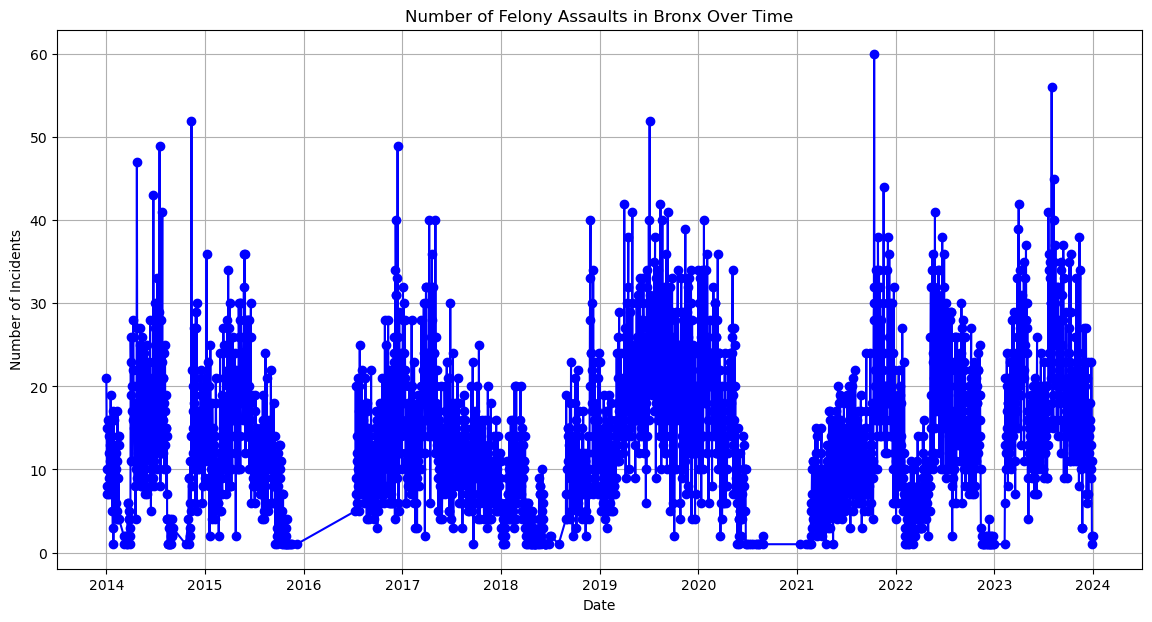

In [12]:
# Filter for 'FELONY ASSAULT' in the Bronx
felony_assault_bronx = historical_df[
    (historical_df['ofns_desc'] == 'FELONY ASSAULT') &
    (historical_df['arrest_boro'] == 'B')
]

# Group by date and count occurrences
date_counts = felony_assault_bronx.groupby('arrest_date').size()

# Plotting the data
plt.figure(figsize=(14, 7))  # Set the figure size for better visibility
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-', color='b')
plt.title('Number of Felony Assaults in Bronx Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)  # Adding a grid for better readability
plt.show()

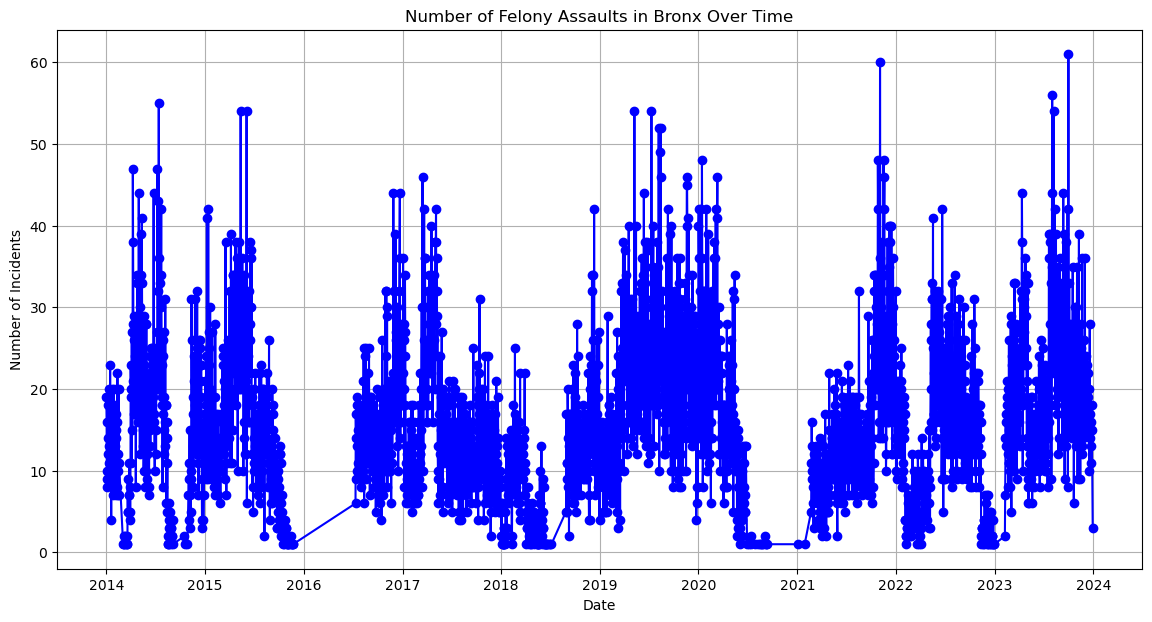

In [14]:
# Filter for 'FELONY ASSAULT' in the Queens
felony_assault_queens = historical_df[
    (historical_df['ofns_desc'] == 'FELONY ASSAULT') &
    (historical_df['arrest_boro'] == 'K')
]

# Group by date and count occurrences
date_counts = felony_assault_queens.groupby('arrest_date').size()

# Plotting the data
plt.figure(figsize=(14, 7))  # Set the figure size for better visibility
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-', color='b')
plt.title('Number of Felony Assaults in Bronx Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)  # Adding a grid for better readability
plt.show()